In [1]:
from PIL import Image
import numpy as np
import torch

In [2]:
def convert(input):
    image = (input / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
    image = Image.fromarray(image)
    return image

In [3]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 3
    save_model_epochs = 10
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [4]:
from diffusers import DDIMScheduler, UNet2DModel
# from diffusers import UniPCMultistepScheduler
# from diffusers import StableDiffusionXLImg2ImgPipeline
# scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
from datasets import load_dataset

config.dataset_name = r"C:\Users\aviator\Music\SIDD_Small_sRGB_Only\noisy_imgs"
dataset = load_dataset(config.dataset_name, split="train")
dataset_1 = load_dataset(path=r"C:\Users\aviator\Music\SIDD_Small_sRGB_Only\clean_imgs", split="train")


Resolving data files:   0%|          | 0/159 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/159 [00:00<?, ?it/s]

In [5]:
import matplotlib 
matplotlib.use('Agg')
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset_1[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

C:\Users\aviator\AppData\Local\Temp\ipykernel_10360\1295343866.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
from PIL import Image

class ConcatenatedDataset(Dataset):
    def __init__(self, dataset1, dataset2, transform=None):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.transform = transform

    def __len__(self):
        # Return the total number of samples in the concatenated dataset
        return max(len(self.dataset1), len(self.dataset2))

    def __getitem__(self, index):
        # Load data from both datasets based on the index
        sample1 = self.dataset1[index % len(self.dataset1)]
        sample2 = self.dataset2[index % len(self.dataset2)]

        # Apply transformations if specified
        if self.transform:
            sample1['image'] = self.transform(sample1['image'])
            sample2['image'] = self.transform(sample2['image'])

        # Return a dictionary with keys for different datasets
        return {'noise': sample1['image'], 'clean': sample2['image']}



In [7]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.CenterCrop(config.image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [8]:
concat_dataset= ConcatenatedDataset(dataset,dataset_1,preprocess)

In [9]:
concatenated_dataloader = DataLoader(concat_dataset, batch_size=config.train_batch_size)

In [11]:
for batch in concatenated_dataloader:
    # Access the images from both datasets using the keys 'dataset1' and 'dataset2'
    images_from_dataset1 = batch['noise']
    images_from_dataset2 = batch['clean']

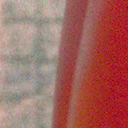

In [14]:
imm=convert(images_from_dataset1[2])
imm

In [ ]:
# def transform(examples):
#     images = [preprocess(image.convert("RGB")) for image in examples["image"]]
#     return {"images": images}


# dataset.set_transform(transform)

In [ ]:
concat_dataset

In [ ]:
# import torch

# train_dataloader = torch.utils.data.DataLoader(concat_dataset, batch_size=config.train_batch_size, shuffle=True)

In [ ]:
# data = train_dataloader.dataset.data 
# shape = train_dataloader.dataset.data.shape  
# # datatype = train_dataloader.dataset.data.dtype
# print(data)
# # print(shape)
# # print()

In [10]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [11]:
sample_image = concat_dataset[0]["noise"].unsqueeze(0)
print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


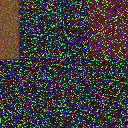

In [12]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [13]:
torch.LongTensor([50])

tensor([50])

In [14]:
# import torch.nn.functional as F

# noise_pred = model(noisy_image, timesteps).sample
# loss = F.mse_loss(noise_pred, noise)

In [15]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(concatenated_dataloader) * config.num_epochs),
)

In [16]:
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [21]:
for step, batch in enumerate(concatenated_dataloader):
    clean_images = batch["clean"]
    noisy_images = batch['noise']
    break

In [23]:
noisy_images.shape

torch.Size([16, 3, 128, 128])

In [17]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
import torch.nn.functional as F

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
        
        for step, batch in enumerate(train_dataloader):
            clean_images = batch["clean"]
            noisy_images = batch["noise"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images_extra = noise_scheduler.add_noise(noisy_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images_extra, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, clean_images)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                print("-"*50+"evaluating"+"-"*50)
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    print("-"*50+"saving model checkpoint"+"-"*50)
                    pipeline.save_pretrained(config.output_dir)

In [18]:

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg)
    plt.imshow(np.transpose(npimg, (1, 2, 0, 1)))


In [19]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, concatenated_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
imgiter=iter(train_dataloader)
images=next(imgiter)



In [26]:
for i in range(images['images'].shape[0]):
    im=convert(images['images'][i])
    im.show()

In [11]:
time_stepss=50

In [12]:
scheduler.set_timesteps(time_stepss)

In [13]:
scheduler.timesteps

tensor([999, 979, 959, 939, 919, 899, 879, 859, 839, 819, 799, 779, 759, 739,
        719, 699, 679, 659, 639, 619, 599, 579, 559, 539, 519, 500, 480, 460,
        440, 420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180,
        160, 140, 120, 100,  80,  60,  40,  20])

In [15]:
model.config

FrozenDict([('vae', ('diffusers', 'AutoencoderKL')),
            ('text_encoder', (None, None)),
            ('text_encoder_2',
             ('transformers', 'CLIPTextModelWithProjection')),
            ('tokenizer', (None, None)),
            ('tokenizer_2', ('transformers', 'CLIPTokenizer')),
            ('unet', ('diffusers', 'UNet2DConditionModel')),
            ('scheduler', ('diffusers', 'EulerDiscreteScheduler')),
            ('force_zeros_for_empty_prompt', False),
            ('requires_aesthetics_score', True),
            ('_name_or_path', 'stabilityai/stable-diffusion-xl-refiner-1.0')])

In [16]:
import torch

# sample_size = model.config.sample_size
sample_size = 512
noise = torch.randn((1, 3, sample_size, sample_size)).to("cuda")

In [17]:
sample_size

512

In [8]:
# from PIL import Image
# import matplotlib.pyplot as plt
# from torchvision import transforms
# noise = Image.open(r"C:\Users\aviator\Downloads\NOISY_SRGB_010.PNG")
# noise=noise.resize((512,512))
# # plt.imshow(transforms.ToPILImage()(transforms.ToTensor()(noise)), interpolation="bicubic")

In [9]:
# noise=(transforms.ToTensor()(noise)).to("cuda")
# noise = noise.unsqueeze(0)

In [18]:
noise

tensor([[[[-0.6454,  2.3749,  0.4882,  ...,  1.2333,  0.6967, -1.0811],
          [ 0.6067, -0.1706, -0.7836,  ..., -1.2228,  0.3016, -0.8027],
          [-0.0290,  0.6683, -1.4934,  ...,  0.4589,  0.7935, -1.4147],
          ...,
          [ 1.0664, -1.6792, -0.5711,  ...,  1.7293,  0.8917,  0.1167],
          [ 2.4953, -0.1732,  0.6680,  ...,  0.1186, -0.7055, -0.3666],
          [ 1.3531,  1.5257,  1.9259,  ..., -0.1274, -0.0474, -0.8287]],

         [[-1.1302, -0.8830, -0.1838,  ..., -1.4737,  0.3993, -0.9382],
          [ 0.5896, -0.9568,  1.3456,  ..., -1.1306, -0.1141, -1.3077],
          [-0.1452, -0.5827, -1.0103,  ...,  0.8667, -1.0769,  0.2313],
          ...,
          [-0.4082, -0.5518,  0.6080,  ..., -0.0298, -0.7142,  1.0932],
          [ 0.4261,  0.3827, -1.9585,  ...,  0.6998, -0.8853,  0.2396],
          [-1.0714,  1.2765,  0.3549,  ..., -0.0957, -0.1082, -1.7692]],

         [[ 0.0933, -0.2658,  1.5274,  ...,  0.1432,  1.3031, -0.7844],
          [ 2.3701,  0.3338, -

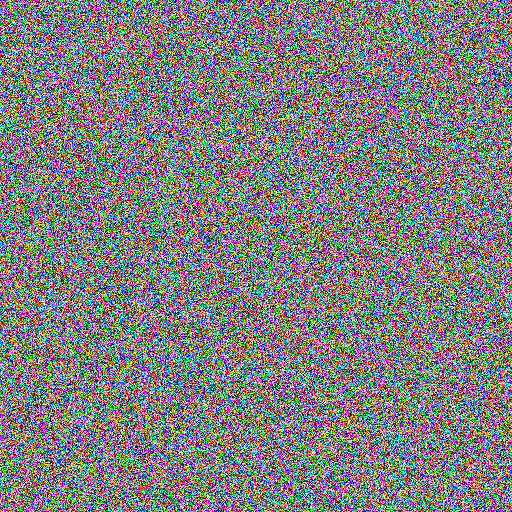

In [19]:
imgg=convert(noise)
imgg

In [21]:
input = noise
print(input.shape)
for t in scheduler.timesteps:
    print(t)
    with torch.no_grad():
        noisy_residual = model(prompt="High quality, denoised",
            negative_prompt="noisy,grainy,low quality",
            Image=input).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample
    img=convert(input)
    display(img)

torch.Size([1, 3, 512, 512])
tensor(999)


TypeError: 'NoneType' object is not iterable

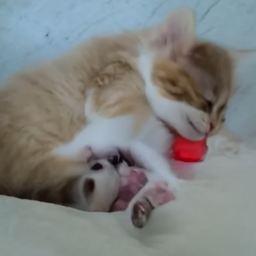

In [13]:
img=convert(input)
display(img)